<a href="https://colab.research.google.com/github/dasjyotishka/Predicting-Airbnb-Prices-in-New-York-City/blob/main/Predicting_price_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#Read dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ensemble/project_airbnb/dataset/AB_NYC_2019.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


#Feature analysis


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
# Checking how many null values there are in each column
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-27-4407c4976e35>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1.00,0.59,-0.00,0.09,0.01,-0.01,-0.32,0.29,0.13,0.09
host_id,0.59,1.00,0.02,0.13,0.02,-0.02,-0.14,0.30,0.15,0.20
latitude,-0.00,0.02,1.00,0.08,0.03,0.02,-0.02,-0.01,0.02,-0.01
longitude,0.09,0.13,0.08,1.00,-0.15,-0.06,0.06,0.15,-0.11,0.08
price,0.01,0.02,0.03,-0.15,1.00,0.04,-0.05,-0.03,0.06,0.08
minimum_nights,-0.01,-0.02,0.02,-0.06,0.04,1.00,-0.08,-0.12,0.13,0.14
number_of_reviews,-0.32,-0.14,-0.02,0.06,-0.05,-0.08,1.00,0.55,-0.07,0.17
reviews_per_month,0.29,0.30,-0.01,0.15,-0.03,-0.12,0.55,1.00,-0.01,0.19
calculated_host_listings_count,0.13,0.15,0.02,-0.11,0.06,0.13,-0.07,-0.01,1.00,0.23
availability_365,0.09,0.20,-0.01,0.08,0.08,0.14,0.17,0.19,0.23,1.00


#Data Cleaning

###Removing null values

In [ ]:
name_null_values = data.name.isnull()
host_null_values = data.host_name.isnull()
print('Percentage of data with an empty name:', len(data.loc[name_null_values])/len(data.id)*100)
print('Percentage of data with an empty host name:', len(data.loc[host_null_values])/len(data.id)*100)

Percentage of data with an empty name: 0.03272318232948154
Percentage of data with an empty host name: 0.04294917680744453


Since these are insignificant percentages of data, hence these rows can be ignored/removed.

In [ ]:
data = data.loc[~name_null_values]
data = data.loc[~host_null_values]
data.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10037
reviews_per_month                 10037
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
data[data['last_review'].isnull()][['number_of_reviews','reviews_per_month']].head()

,number_of_reviews,reviews_per_month
2,0,NaN
19,0,NaN
26,0,NaN
36,0,NaN
38,0,NaN


If a certain listing has a null for its "last_review," that means it has not gotten a review at all(also proved from previous dataframe), so "reviews_per_month" must be 0. 
Also, now we can drop the last-review column containing null values from a cleaner dataset.


In [ ]:
data.fillna({'reviews_per_month':0}, inplace=True)
data.drop('last_review', inplace=True, axis=1)
data.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

#Data Visualisations

[Text(0, 0, '25393'), Text(0, 0, '22306'), Text(0, 0, '1159')]

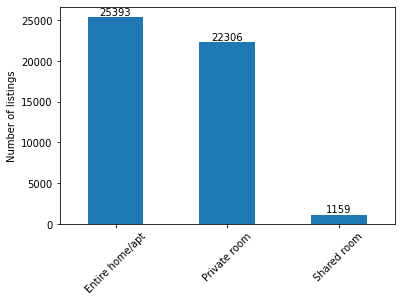

In [ ]:
#room-type counts graph
ax4 = data.room_type.value_counts().plot.bar(rot=45)
ax4.set_ylabel("Number of listings")
ax4.bar_label(ax4.containers[0])

We see maximum listings are either Private room or Entire home/apt

In [ ]:
#Avg. price and listings per neighbourhood_group(large area)
neighbourhood_group_df = data.groupby('neighbourhood_group').agg(avg_price=('price','mean'),
                       count=('price','count')).reset_index()
    
neighbourhood_group_df

,neighbourhood_group,avg_price,count
0,Bronx,87.469238,1089
1,Brooklyn,124.410523,20089
2,Manhattan,196.897473,21643
3,Queens,99.536017,5664
4,Staten Island,114.812332,373


Text(0, 0.5, '')

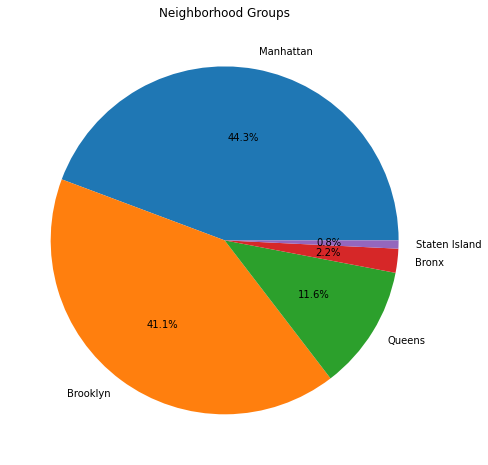

In [ ]:
#Pie chart to show listings in each neighbourhood group
ax1 = data.neighbourhood_group.value_counts().plot.pie(title='Neighborhood Groups',
                                               figsize=(8,8),
                                              autopct='%1.1f%%')
ax1.set_ylabel(None)

We see that more than 85% of listings are located in Manhattan and Brooklyn.

<AxesSubplot:xlabel='neighbourhood_group'>

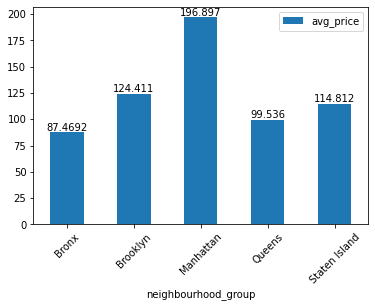

In [ ]:
ax4 = neighbourhood_group_df.plot.bar(rot=45, x='neighbourhood_group', y='avg_price')
ax4.bar_label(ax4.containers[0])
ax4

We see that highest average price is of listings are located in Manhattan

In [ ]:
data.groupby('neighbourhood').agg(avg_price=('price','mean'),
                       count=('price','count')).sort_values('count', ascending=False).reset_index()

,neighbourhood,avg_price,count
0,Williamsburg,143.826142,3917
1,Bedford-Stuyvesant,107.688392,3713
2,Harlem,118.952542,2655
3,Bushwick,84.815597,2462
4,Upper West Side,210.990350,1969
5,Hell's Kitchen,204.931934,1954
6,East Village,186.075594,1852
7,Upper East Side,188.872565,1797
8,Crown Heights,112.520154,1563
9,Midtown,282.719094,1545


In [ ]:
neighbourhood_df = data.groupby('neighbourhood', as_index=False)['price'].count()
neighbourhood_df = neighbourhood_df.rename(columns={'price':'count'})
neighbourhood_df

,neighbourhood,count
0,Allerton,42
1,Arden Heights,4
2,Arrochar,21
3,Arverne,77
4,Astoria,900
5,Bath Beach,17
6,Battery Park City,69
7,Bay Ridge,141
8,Bay Terrace,6
9,"Bay Terrace, Staten Island",2


In [ ]:
df_new = data[['host_id', 'latitude', 'longitude', 'price',
             'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'neighbourhood_group', 'neighbourhood', 'room_type']]
print(df_new.shape)
df_new.head()

(48858, 10)


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,neighbourhood_group,neighbourhood,room_type
0,2787,40.64749,-73.97237,149,1,9,0.21,Brooklyn,Kensington,Private room
1,2845,40.75362,-73.98377,225,1,45,0.38,Manhattan,Midtown,Entire home/apt
2,4632,40.80902,-73.94190,150,3,0,0.00,Manhattan,Harlem,Private room
3,4869,40.68514,-73.95976,89,1,270,4.64,Brooklyn,Clinton Hill,Entire home/apt
4,7192,40.79851,-73.94399,80,10,9,0.10,Manhattan,East Harlem,Entire home/apt


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create a label encoder object
le = LabelEncoder()

In [ ]:
# convert rest of categorical variable into dummy
df_new = pd.get_dummies(df_new, drop_first=True)

In [ ]:
print(df_new.shape)
df_new.head()

(48858, 233)


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,neighbourhood_Cambria Heights,neighbourhood_Canarsie,neighbourhood_Carroll Gardens,neighbourhood_Castle Hill,neighbourhood_Castleton Corners,neighbourhood_Chelsea,neighbourhood_Chinatown,neighbourhood_City Island,neighbourhood_Civic Center,neighbourhood_Claremont Village,neighbourhood_Clason Point,neighbourhood_Clifton,neighbourhood_Clinton Hill,neighbourhood_Co-op City,neighbourhood_Cobble Hill,neighbourhood_College Point,neighbourhood_Columbia St,neighbourhood_Concord,neighbourhood_Concourse,neighbourhood_Concourse Village,neighbourhood_Coney Island,neighbourhood_Corona,neighbourhood_Crown Heights,neighbourhood_Cypress Hills,neighbourhood_DUMBO,neighbourhood_Ditmars Steinway,neighbourhood_Dongan Hills,neighbourhood_Douglaston,neighbourhood_Downtown Brooklyn,neighbourhood_Dyker Heights,neighbourhood_East Elmhurst,neighbourhood_East Flatbush,neighbourhood_East Harlem,neighbourhood_East Morrisania,neighbourhood_East New York,neighbourhood_East Village,neighbourhood_Eastchester,neighbourhood_Edenwald,neighbourhood_Edgemere,neighbourhood_Elmhurst,neighbourhood_Eltingville,neighbourhood_Emerson Hill,neighbourhood_Far Rockaway,neighbourhood_Fieldston,neighbourhood_Financial District,neighbourhood_Flatbush,neighbourhood_Flatiron District,neighbourhood_Flatlands,neighbourhood_Flushing,neighbourhood_Fordham,neighbourhood_Forest Hills,neighbourhood_Fort Greene,neighbourhood_Fort Hamilton,neighbourhood_Fort Wadsworth,neighbourhood_Fresh Meadows,neighbourhood_Glendale,neighbourhood_Gowanus,neighbourhood_Gramercy,neighbourhood_Graniteville,neighbourhood_Grant City,neighbourhood_Gravesend,neighbourhood_Great Kills,neighbourhood_Greenpoint,neighbourhood_Greenwich Village,neighbourhood_Grymes Hill,neighbourhood_Harlem,neighbourhood_Hell's Kitchen,neighbourhood_Highbridge,neighbourhood_Hollis,neighbourhood_Holliswood,neighbourhood_Howard Beach,neighbourhood_Howland Hook,neighbourhood_Huguenot,neighbourhood_Hunts Point,neighbourhood_Inwood,neighbourhood_Jackson Heights,neighbourhood_Jamaica,neighbourhood_Jamaica Estates,neighbourhood_Jamaica Hills,neighbourhood_Kensington,neighbourhood_Kew Gardens,neighbourhood_Kew Gardens Hills,neighbourhood_Kingsbridge,neighbourhood_Kips Bay,neighbourhood_Laurelton,neighbourhood_Lighthouse Hill,neighbourhood_Little Italy,neighbourhood_Little Neck,neighbourhood_Long Island City,neighbourhood_Longwood,neighbourhood_Lower East Side,neighbourhood_Manhattan Beach,neighbourhood_Marble Hill,neighbourhood_Mariners Harbor,neighbourhood_Maspeth,neighbourhood_Melrose,neighbourhood_Middle Village,neighbourhood_Midland Beach,neighbourhood_Midtown,neighbourhood_Midwood,neighbourhood_Mill Basin,neighbourhood_Morningside Heights,neighbourhood_Morris Heights,neighbourhood_Morris Park,neighbourhood_Morrisania,neighbourhood_Mott Haven,neighbourhood_Mount Eden,neighbourhood_Mount Hope,neighbourhood_Murray Hill,neighbourhood_Navy Yard,neighbourhood_Neponsit,neighbourhood_New Brighton,neighbourhood_New Dorp,neighbourhood_New Dorp Beach,neighbourhood_New Springville,neighbourhood_NoHo,neighbourhood_Nolita,

In [ ]:
#Feature scaling using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
data_col = list(df_new.columns)
data_col.remove('price')
print(data_col)

['host_id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'neighbourhood_Arden Heights', 'neighbourhood_Arrochar', 'neighbourhood_Arverne', 'neighbourhood_Astoria', 'neighbourhood_Bath Beach', 'neighbourhood_Battery Park City', 'neighbourhood_Bay Ridge', 'neighbourhood_Bay Terrace', 'neighbourhood_Bay Terrace, Staten Island', 'neighbourhood_Baychester', 'neighbourhood_Bayside', 'neighbourhood_Bayswater', 'neighbourhood_Bedford-Stuyvesant', 'neighbourhood_Belle Harbor', 'neighbourhood_Bellerose', 'neighbourhood_Belmont', 'neighbourhood_Bensonhurst', 'neighbourhood_Bergen Beach', 'neighbourhood_Boerum Hill', 'neighbourhood_Borough Park', 'neighbourhood_Breezy Point', 'neighbourhood_Briarwood', 'neighbourhood_Brighton Beach', 'neighbourhood_Bronxdale', 'neighbourhood_Brooklyn Heights', 'neighbourhood_Brownsville', "neigh

In [ ]:
for col in data_col:
    df_new[col] = df_new[col].astype(float)
    df_new[[col]] = scaler.fit_transform(df_new[[col]])
#data['price'] = pd.to_numeric(data['price'], downcast='float')
df_new.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,neighbourhood_Cambria Heights,neighbourhood_Canarsie,neighbourhood_Carroll Gardens,neighbourhood_Castle Hill,neighbourhood_Castleton Corners,neighbourhood_Chelsea,neighbourhood_Chinatown,neighbourhood_City Island,neighbourhood_Civic Center,neighbourhood_Claremont Village,neighbourhood_Clason Point,neighbourhood_Clifton,neighbourhood_Clinton Hill,neighbourhood_Co-op City,neighbourhood_Cobble Hill,neighbourhood_College Point,neighbourhood_Columbia St,neighbourhood_Concord,neighbourhood_Concourse,neighbourhood_Concourse Village,neighbourhood_Coney Island,neighbourhood_Corona,neighbourhood_Crown Heights,neighbourhood_Cypress Hills,neighbourhood_DUMBO,neighbourhood_Ditmars Steinway,neighbourhood_Dongan Hills,neighbourhood_Douglaston,neighbourhood_Downtown Brooklyn,neighbourhood_Dyker Heights,neighbourhood_East Elmhurst,neighbourhood_East Flatbush,neighbourhood_East Harlem,neighbourhood_East Morrisania,neighbourhood_East New York,neighbourhood_East Village,neighbourhood_Eastchester,neighbourhood_Edenwald,neighbourhood_Edgemere,neighbourhood_Elmhurst,neighbourhood_Eltingville,neighbourhood_Emerson Hill,neighbourhood_Far Rockaway,neighbourhood_Fieldston,neighbourhood_Financial District,neighbourhood_Flatbush,neighbourhood_Flatiron District,neighbourhood_Flatlands,neighbourhood_Flushing,neighbourhood_Fordham,neighbourhood_Forest Hills,neighbourhood_Fort Greene,neighbourhood_Fort Hamilton,neighbourhood_Fort Wadsworth,neighbourhood_Fresh Meadows,neighbourhood_Glendale,neighbourhood_Gowanus,neighbourhood_Gramercy,neighbourhood_Graniteville,neighbourhood_Grant City,neighbourhood_Gravesend,neighbourhood_Great Kills,neighbourhood_Greenpoint,neighbourhood_Greenwich Village,neighbourhood_Grymes Hill,neighbourhood_Harlem,neighbourhood_Hell's Kitchen,neighbourhood_Highbridge,neighbourhood_Hollis,neighbourhood_Holliswood,neighbourhood_Howard Beach,neighbourhood_Howland Hook,neighbourhood_Huguenot,neighbourhood_Hunts Point,neighbourhood_Inwood,neighbourhood_Jackson Heights,neighbourhood_Jamaica,neighbourhood_Jamaica Estates,neighbourhood_Jamaica Hills,neighbourhood_Kensington,neighbourhood_Kew Gardens,neighbourhood_Kew Gardens Hills,neighbourhood_Kingsbridge,neighbourhood_Kips Bay,neighbourhood_Laurelton,neighbourhood_Lighthouse Hill,neighbourhood_Little Italy,neighbourhood_Little Neck,neighbourhood_Long Island City,neighbourhood_Longwood,neighbourhood_Lower East Side,neighbourhood_Manhattan Beach,neighbourhood_Marble Hill,neighbourhood_Mariners Harbor,neighbourhood_Maspeth,neighbourhood_Melrose,neighbourhood_Middle Village,neighbourhood_Midland Beach,neighbourhood_Midtown,neighbourhood_Midwood,neighbourhood_Mill Basin,neighbourhood_Morningside Heights,neighbourhood_Morris Heights,neighbourhood_Morris Park,neighbourhood_Morrisania,neighbourhood_Mott Haven,neighbourhood_Mount Eden,neighbourhood_Mount Hope,neighbourhood_Murray Hill,neighbourhood_Navy Yard,neighbourhood_Neponsit,neighbourhood_New Brighton,neighbourhood_New Dorp,neighbourhood_New Dorp Beach,neighbourhood_New Springville,neighbourhood_NoHo,neighbourhood_Nolita,

### Splitting data into training and testing sets

> Prior to implementating or applying any Machine Learning algorithms, we must decouple training and testing datasets from our master dataframe.

In [ ]:
# assign the target to a new dataframe and convert it to a numerical feature
#df_target = df_HR[['Attrition']].copy()
target = df_new['price'].copy()
type(target)

pandas.core.series.Series

In [ ]:
# let's remove the target feature and redundant features from the dataset
df_new.drop(['price'], axis=1, inplace=True)
print('Size of Full dataset is: {}'.format(df_new.shape))

Size of Full dataset is: (48858, 232)


In [ ]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(df_new, target)


RandomForestRegressor(random_state=0)

In [ ]:
Y_pred = regressor.predict(np.array([6.5]).reshape(1, 1)) # test the output by changing values


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: ignored

In [ ]:
# Visualising the Random Forest Regression results

# arrange for creating a range of values
# from min value of x to max
# value of x with a difference of 0.01
# between two consecutive values
X_grid = np.arange(min(df_new), max(df_new), 0.01)

# reshape for reshaping the data into a len(X_grid)*1 array,
# i.e. to make a column out of the X_grid value				
X_grid = X_grid.reshape((len(X_grid), 1))

# Scatter plot for original data
plt.scatter(df_new, target, color = 'blue')

# plot predicted data
plt.plot(X_grid, regressor.predict(X_grid),
		color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('Features of the apartments')
plt.ylabel('Price')
plt.show()


TypeError: ignored